In [1]:
import pickle
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
from hdbscan import HDBSCAN
from sklearn.manifold import TSNE
import os
import matplotlib.pyplot as plt
%matplotlib inline

 

In [2]:
min_track_length = 10
track_smoothing_window_size = 15
track_smoothing_std = .5
num_discretization_bins = 72

num_batches = 300
num_hidden = 20  # hochsetzen --> mächtigeres Modell
batch_size = 32


In [3]:
tracks = np.load("Tracks.npy")
print(np.array(tracks).shape)
num_features = tracks[0].shape[-1]

(27600, 200, 110)


In [4]:
def get_equal_discretization_bins(data, bins):
    """
    create equally sized bins bewteen minium and maximum value,
    excluding start- and endpoint

    Parameters
    ----------
    data : ndarray
        feature data of all agents concatenated
    bins : int
        number of bins
    """
    min_data = min(data)
    max_data = max(data)
    ret_bins = np.linspace(min_data, max_data, bins, endpoint=False)
    ret_bins = np.delete(ret_bins, 0)
    return ret_bins

# Find out the bins

discretization_bins = []
concatenated_tracks = np.concatenate(tracks)
for feature_i in range(2):
    discretization_bins.append(get_equal_discretization_bins(concatenated_tracks[:, feature_i], num_discretization_bins))
del(concatenated_tracks)
np.save("Bins",discretization_bins)

In [5]:
# Digitize all values into the bins
def digitize_track(track):
    for feature_i in range(2):
        track[:, feature_i] = np.digitize(track[:, feature_i], discretization_bins[feature_i], right=True)
    return track.astype(np.int32)

### MODEL SET UP BEGINS

np.random.shuffle(tracks)
train_tracks = tracks[:int(.8 * len(tracks))]
val_tracks = tracks[int(.8 * len(tracks)):]
print(len(train_tracks), len(val_tracks))


22080 5520


In [6]:
tf.reset_default_graph()

track_continuous = tf.placeholder(tf.float32, shape=(None, min_track_length, num_features), name='track_continuous')
track_discrete = tf.placeholder(tf.int32, shape=(None, min_track_length, num_features), name='track_discrete')

num_outputs = 2

inputs = track_continuous[:, :-1, :]
targets = track_discrete[:, 1:, :num_outputs]

with tf.variable_scope('discriminator'):
    disc_hidden_0, _ = tf.nn.dynamic_rnn(
        tf.contrib.rnn.GRUCell(num_hidden), 
        inputs, dtype=tf.float32, scope='disc_hidden_0')
    disc_hidden_1, _ = tf.nn.dynamic_rnn(
        tf.contrib.rnn.GRUCell(num_hidden), 
        disc_hidden_0, dtype=tf.float32, scope='disc_hidden_1')
    disc_hidden_2, _ = tf.nn.dynamic_rnn(
        tf.contrib.rnn.GRUCell(num_hidden), 
        disc_hidden_1, dtype=tf.float32, scope='disc_hidden_2')
    # add optional classifier here
    
with tf.variable_scope('generator'):
    gen_hidden_2, _ = tf.nn.dynamic_rnn(
        tf.contrib.rnn.GRUCell(num_hidden), 
        disc_hidden_2, dtype=tf.float32, scope='gen_hidden_2')
    gen_hidden_1_input = tf.concat((gen_hidden_2, disc_hidden_1), axis=2)
    gen_hidden_1, _ = tf.nn.dynamic_rnn(
        tf.contrib.rnn.GRUCell(num_hidden), 
        gen_hidden_1_input, dtype=tf.float32, scope='gen_hidden_1')
    gen_hidden_0_input = tf.concat((gen_hidden_1, disc_hidden_0), axis=2)
    gen_hidden_0, _ = tf.nn.dynamic_rnn(
        tf.contrib.rnn.GRUCell(num_hidden), 
        gen_hidden_0_input, dtype=tf.float32, scope='gen_hidden_0')
    gen_output, _ = tf.nn.dynamic_rnn(
        tf.contrib.rnn.OutputProjectionWrapper(
            tf.contrib.rnn.GRUCell(num_hidden), num_outputs * num_discretization_bins), 
        gen_hidden_0, dtype=tf.float32, scope='gen_features')
    gen_output = tf.reshape(gen_output,
        (tf.shape(gen_output)[0], tf.shape(gen_output)[1], num_outputs, num_discretization_bins), name='gen_output')

# LOSS FUNCTION    
loss = tf.reduce_mean(
    tf.nn.sparse_softmax_cross_entropy_with_logits(
        labels=targets, logits=gen_output))

optimizer = tf.train.AdamOptimizer(0.001)

update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
    update = optimizer.minimize(loss)


In [7]:
def subsample(track):
    start_idx = np.random.randint(0, track.shape[0] - min_track_length)
    end_idx = start_idx + min_track_length
    return track[start_idx:end_idx]

def data_generator(tracks, size=batch_size):
    while True:
        indices = np.random.choice(list(range(len(tracks))), replace=False, size=size)
        samples = [track for idx, track in enumerate(tracks) if idx in indices]
        sampled_tracks = np.array(list(map(subsample, samples)))
        digitized_tracks = np.array(list(map(lambda t: digitize_track(t), np.copy(sampled_tracks))))
        yield sampled_tracks, digitized_tracks

train_gen = data_generator(train_tracks)
val_gen = data_generator(val_tracks)


INFO:tensorflow:Restoring parameters from my-model_1
299: train-logloss: 3.55, val-logloss: 3.55

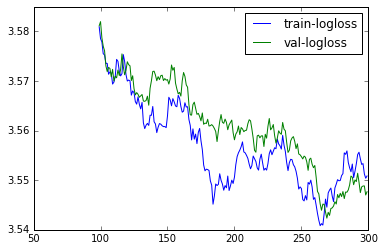

In [8]:
session = tf.Session()
saver = tf.train.Saver()
session.run(tf.global_variables_initializer())

saver.restore(session, 'my-model_1')

train_losses = []
val_losses = []

for batch_idx in range(num_batches):
    samples_continuous, samples_discrete = next(train_gen)
    batch_loss, _ = session.run([loss, update], feed_dict={track_continuous: samples_continuous,
                                              track_discrete: samples_discrete})
    train_losses.append(batch_loss)
    
    samples_continuous, samples_discrete = next(val_gen)
    batch_loss = session.run(loss, feed_dict={track_continuous: samples_continuous,
                                              track_discrete: samples_discrete})
    val_losses.append(batch_loss)
    
    sys.stdout.write('\r{}: train-logloss: {:.2f}, val-logloss: {:.2f}'.format(
        batch_idx, np.mean(train_losses[-100:]), np.mean(val_losses[-100:])))

#saver.save(session, 'my-model_1')
tf.train.export_meta_graph('meta_graph_1')

plt.plot(pd.Series(train_losses).rolling(100).mean(), label='train-logloss')
plt.plot(pd.Series(val_losses).rolling(100).mean(), label='val-logloss')
plt.legend()
plt.show()


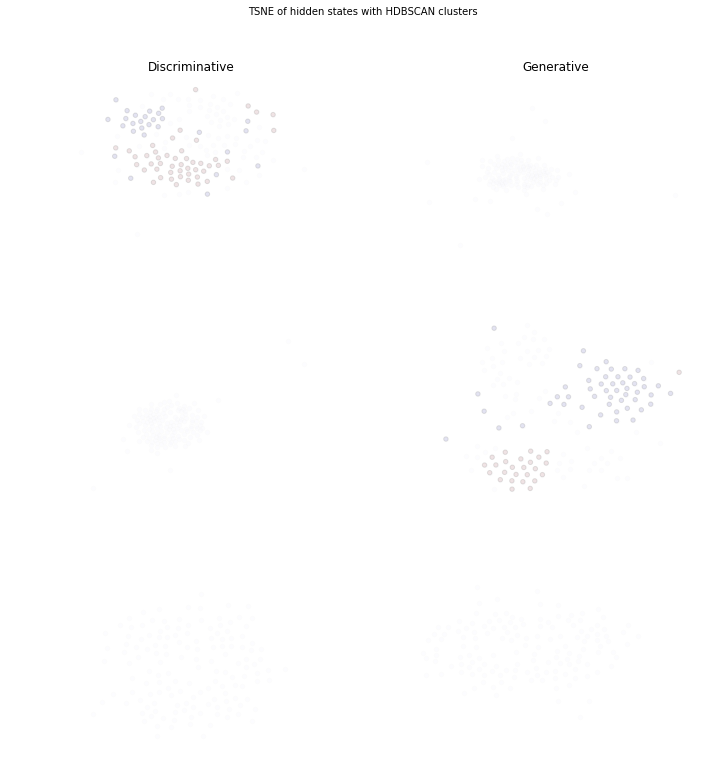

In [9]:
val_gen = data_generator(val_tracks, size=16)
samples_continuous, _ = next(val_gen)

disc_hidden = []
disc_hidden_2d = []
disc_hidden_labels = []

for hidden in (disc_hidden_2, disc_hidden_1, disc_hidden_0):
    hidden_states = session.run(hidden, feed_dict={track_continuous: samples_continuous})
    hidden_states = hidden_states.reshape((-1, hidden_states.shape[-1]))
    hidden_states_2d = TSNE().fit_transform(hidden_states.astype(np.float64))
    clusterer = HDBSCAN(min_cluster_size=25)
    cluster_labels = clusterer.fit_predict(hidden_states)
    disc_hidden.append(hidden_states)
    disc_hidden_2d.append(hidden_states_2d)
    disc_hidden_labels.append(cluster_labels)

gen_hidden = []
gen_hidden_2d = []
gen_hidden_labels = []

for hidden in (gen_hidden_2, gen_hidden_1, gen_hidden_0):
    hidden_states = session.run(hidden, feed_dict={track_continuous: samples_continuous})
    hidden_states = hidden_states.reshape((-1, hidden_states.shape[-1]))
    hidden_states_2d = TSNE().fit_transform(hidden_states.astype(np.float64))
    clusterer = HDBSCAN(min_cluster_size=25)
    cluster_labels = clusterer.fit_predict(hidden_states)
    gen_hidden.append(hidden_states)
    gen_hidden_2d.append(hidden_states_2d)
    gen_hidden_labels.append(cluster_labels)


fig, axes = plt.subplots(3, 2, figsize=(12, 12))

for idx, (hidden, hidden_2d, clusters) in enumerate(zip(disc_hidden, disc_hidden_2d, disc_hidden_labels)):
    cluster_indices = np.where(clusters != -1)[0]
    
    axes[idx, 0].scatter(hidden_2d[:, 0], hidden_2d[:, 1], alpha=.01)
    axes[idx, 0].scatter(hidden_2d[cluster_indices, 0], 
                         hidden_2d[cluster_indices, 1], 
                         alpha=.1, c=clusters[cluster_indices],
                         cmap=plt.cm.jet)
    axes[idx, 0].set_axis_off()
    
axes[0, 0].set_title('Discriminative')
    
for idx, (hidden, hidden_2d, clusters) in enumerate(zip(gen_hidden, gen_hidden_2d, gen_hidden_labels)):
    cluster_indices = np.where(clusters != -1)[0]
    
    axes[idx, 1].scatter(hidden_2d[:, 0], hidden_2d[:, 1], alpha=.01)
    axes[idx, 1].scatter(hidden_2d[cluster_indices, 0], 
                         hidden_2d[cluster_indices, 1], 
                         alpha=.1, c=clusters[cluster_indices],
                         cmap=plt.cm.jet)
    axes[idx, 1].set_axis_off()
    
axes[0, 1].set_title('Generative')
    
_ = plt.suptitle('TSNE of hidden states with HDBSCAN clusters')


